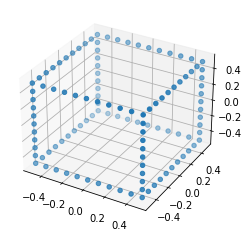

In [209]:
import numpy as np
import matplotlib.pyplot as plt

def box3d(n):
    d_x = d_y = d_z = 1 / n
    x0 = y0 = z0 = -0.5
    x = np.arange(x0, -x0, d_x, dtype=float)
    y = np.arange(y0, -y0, d_y, dtype=float)
    z = np.arange(z0, -z0, d_z, dtype=float)
    x = np.append(x,0.5)
    y = np.append(y,0.5)
    z = np.append(z,0.5)
    cube = np.stack(np.meshgrid(x, y, z))
    # print(cube)
    # one = abs(cube[0,:,:,:]) == 0.5
    # two = abs(cube[1,:,:,:]) == 0.5
    # thr = abs(cube[2,:,:,:]) == 0.5
    # w = np.logical_or(one,two)
    # w = np.logical_or(w,thr)
    # points = cube[:,w].reshape(cube[:,w].shape[1], 3)
    # return points # just sides of the cube
    return cube.reshape(3,-1) # cube
    
Q = box3d(10)
ax = plt.axes(projection='3d')
Q = np.swapaxes(Q,0,1)
Q = Q[(abs(Q) == 0.5).sum(axis=1) >= 2]
# ax.scatter3D(Q[0,:],Q[1,:],Q[2,:])
ones = np.ones(Q.shape[0]).reshape(Q.shape[0],1)
Q = np.concatenate((Q,ones),axis=1)
ax.scatter3D(Q[:,0],Q[:,1],Q[:,2])

[[ 0.8660254  0.         0.5        0.       ]
 [ 0.         1.         0.         0.       ]
 [-0.5        0.         0.8660254  4.       ]]
[[-0.17894026]
 [-0.13099336]
 [ 1.        ]]


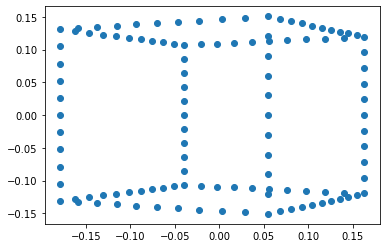

In [210]:
def projectpoints(K, R, t, Q):
    Q.reshape((Q.shape[1],Q.shape[0]))
    T = np.concatenate((R,t),axis=1)
    P = K @ T
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        p = Q[i,:]
        projected = P @ p.reshape(4,1)
        if (p == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(P)
            print(projected/projected[2])
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx,ppsy

K = R = np.eye(3)
theta = np.pi / 6
R = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)],
])
t = np.array([[0,0,4]]).T
(ppsx,ppsy) = projectpoints(K,R,t,Q)
plt.scatter(ppsx, ppsy) # 2D image

### Week2

[[600.    0.  400.  600. ]
 [  0.  600.  400.  720. ]
 [  0.    0.    1.    1.5]]
[[100.]
 [220.]
 [  1.]]


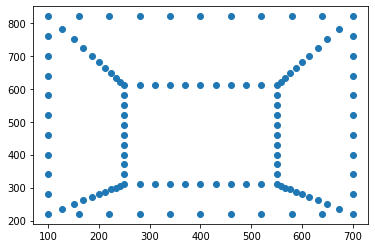

In [211]:
def build_K(f,alpha,beta,deltax,deltay):
    return np.array([
        [f, beta*f, deltax],
        [0, alpha*f, deltay],
        [0, 0, 1]
    ])
f = 600
alpha = 1
beta = 0
deltax = deltay = 400
K = build_K(f,alpha,beta,deltax,deltay)
R = np.eye(3)
t = np.array([[0,.2,1.5]]).T
(ppsx,ppsy) = projectpoints(K,R,t,Q)
plt.scatter(ppsx, ppsy) # 2D image
# TODO: projection matrix (4,4) element doesn't agree with the exercise doc

In [212]:
max(ppsy) # this is out of image sensor 

820.0

In [213]:
def distortion(p, dr):
    dr 
    return p * (1 + dr * np.linalg.norm(p,2))

def tinhom3D(p):
    s = p[3][0]
    for i in range(3):
        p[i][0] /= s
    return p[:3]

def tinhom2D(p):
    s = p[2][0]
    for i in range(2):
        p[i][0] /= s
    return p[:2]

def thom(p):
    return np.append(p,np.ones((1,1)),axis=0)

[[2.10914268e+04]
 [1.28148561e+04]
 [1.00000000e+00]]


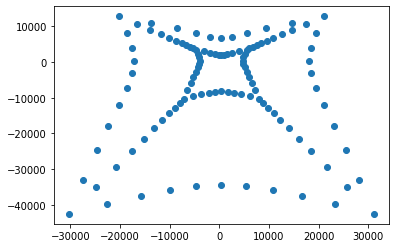

In [222]:
f = 600
alpha = 1
beta = 0
deltax = deltay = 400
K = build_K(f,alpha,beta,deltax,deltay)
R = np.eye(3)
t = np.array([[0,.2,1.5]]).T
Ap = np.array([
    [f,0,0],
    [0,f,0],
    [0,0,1],
])
Aq = np.array([
    [1,beta,deltax],
    [0,alpha,deltay],
    [0,0,1],
])

# data = np.zeros((800,800))
# center = [400, 400]
# y, x = np.indices((data.shape))
# r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
# # import matplotlib.pyplot as plt
# # plt.imshow(r, cmap='gray')

# lecture notes
def projectpoints(K, R, t, Q, dist):
    Q.reshape((Q.shape[1],Q.shape[0]))
    T = np.concatenate((R,t),axis=1)
    # T = np.append(T,np.array([[0,0,0,1]]),axis=0)
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        Qi = Q[i,:].copy()
        pid = Ap @ T @ Qi.reshape(4,1)
        pid = tinhom2D(pid)
        # pid[0][0] -= deltax
        # pid[1][0] -= deltay
        r = np.linalg.norm(pid,2)
        # dr = 0.0
        # for i,d in enumerate(dist):
        #     dr += d*r**((i+1)*2)
        dr = -.2*r
        pic = pid * (1 + dr)
        pic = thom(pic)
        projected = Aq @ pic
        if (Qi == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx,ppsy

dist_coeffs = [1.0,2.0,3.0]
(ppsx,ppsy) = projectpoints(K,R,t,Q,dist_coeffs)
plt.scatter(ppsx, ppsy) # 2D image

[[120.4 ]
 [232.24]
 [  1.  ]]


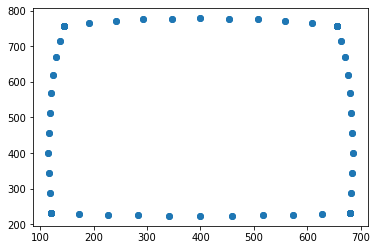

In [231]:
# slides math
def projectpoints(K, R, t, Q, dist):
    Q.reshape((Q.shape[1],Q.shape[0]))
    T = np.concatenate((R,t),axis=1)
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        Qi = Q[i,:].copy()
        pid = T @ Qi.reshape(4,1)
        pid = pid[:2]
        pid = pid * (1 - .2*np.linalg.norm(pid,2)**2)
        pid = np.append(pid,np.ones((1,1)),axis=0)
        projected = K @ pid
        if (Qi == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx,ppsy

dist_coeffs = [1.0,2.0,3.0]
(ppsx,ppsy) = projectpoints(K,R,t,Q,dist_coeffs)
plt.scatter(ppsx, ppsy) # 2D image